In [1]:
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

Recreate orbit from PW & B 2018:

In [2]:
pot = gp.load('/Users/apricewhelan/projects/gd1-dr2/output/mwpot.yml')
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)

phi1_0 = -20*u.deg
tmp = {'phi2': 3.53709061e-02*u.deg,
       'distance': 8.897*u.kpc, 
       'pm_phi1_cosphi2': -10*u.mas/u.yr, 
       'pm_phi2': -2.27160328*u.mas/u.yr, 
       'radial_velocity': -1.38114555e+02*u.km/u.s}

w0 = gc.GD1(phi1=phi1_0, **tmp).transform_to(gc_frame)
w0 = gd.PhaseSpacePosition(w0.data)

/Users/apricewhelan/projects/gala/gala/potential/potential/io.py:201: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  p_dict = yaml.load(fil.read())


In [3]:
orbit = pot.integrate_orbit(w0, dt=1, n_steps=10_000)

In [4]:
orbit.pericenter(), orbit.apocenter()

(<Quantity 14.34389736 kpc>, <Quantity 16.35859045 kpc>)

GD-1 occupies the ~12–18 kpc annulus

---

In [139]:
a = -0.749
b = 1.088
c = 0.118
mu1 = 0.042
mu_cut = 0.199
Mvir12 = 10**12

Reproducing Figure 12 in Bullock & Boylan-Kolchin 2017

(1e-05, 1)

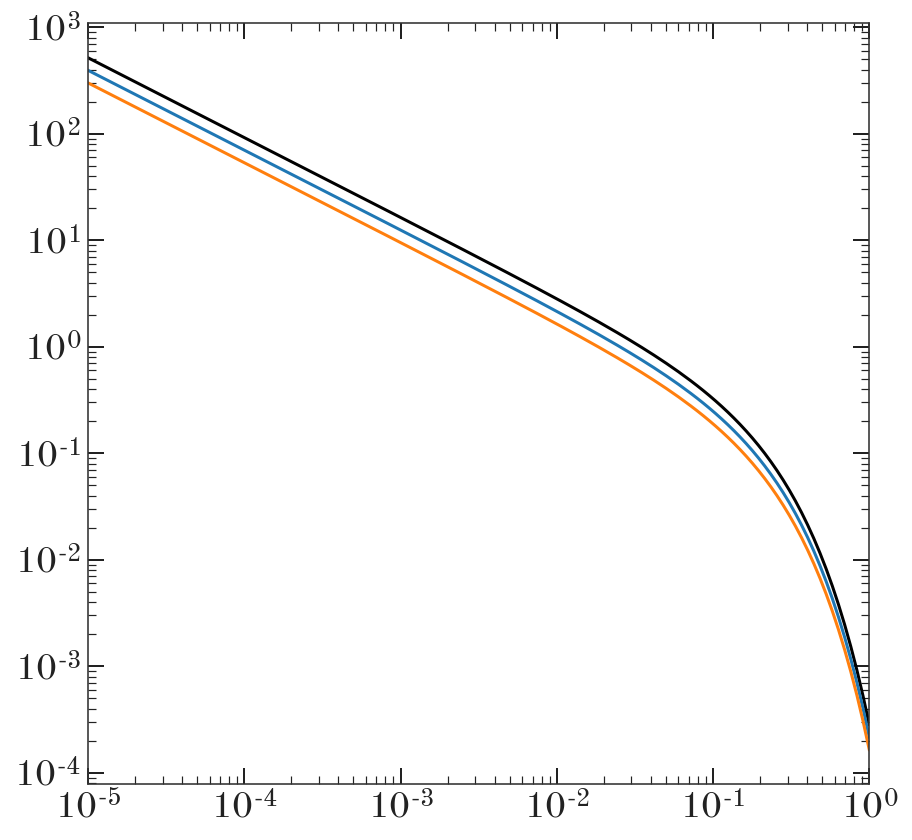

In [140]:
plt.figure(figsize=(7, 7))

mu = np.logspace(-5, 0, 128)
for M in [1e12, 1e11, 1e10]:
    mu0 = (M / 1e12)**c
    N_gtr_mu = mu0 * (mu/mu1)**a * np.exp(-(mu/mu_cut)**b)
    plt.loglog(mu, N_gtr_mu, marker='')
    
plt.xlim(1e-5, 1)

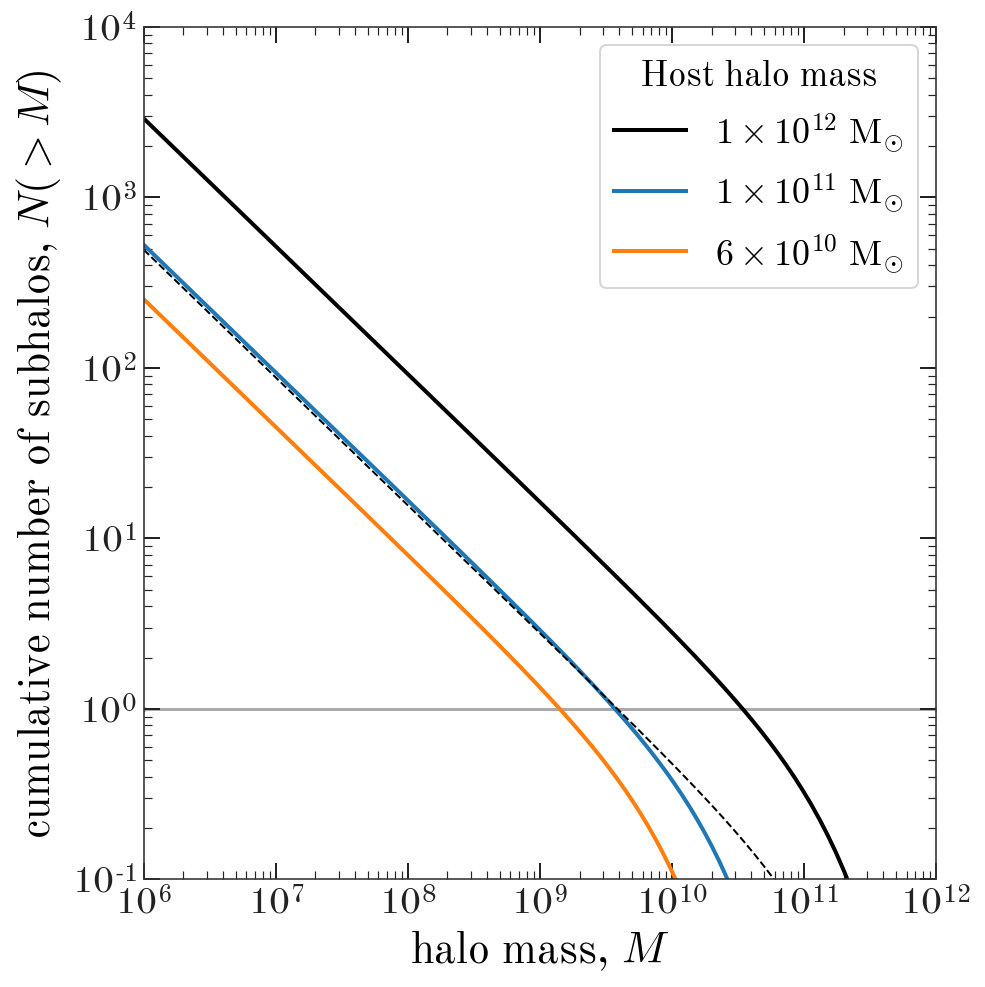

In [143]:
plt.figure(figsize=(7, 7))

for M in [1e12, 1.4e11, 6e10]:
    Msub = np.geomspace(1e4, M, 128)
    mu = Msub / M
    mu0 = (M / 1e12)**c
    N_gtr_mu = mu0 * (mu/mu1)**a * np.exp(-(mu/mu_cut)**b)
    
    fac, exp = '{:.0e}'.format(M).split('e+')
    label = fr"${fac}\times10^{{{exp}}}$"
    plt.loglog(Msub, N_gtr_mu, marker='', lw=2,
               label=label + f' {u.Msun:latex_inline}')
    
plt.xlim(1e6, 1e12)
plt.ylim(1e-1, 1e4)
plt.axhline(1, zorder=-10, color='#aaaaaa')

plt.legend(fontsize=18, title='Host halo mass', title_fontsize=18)

# Fraction of MW subhalos in 10–30 kpc range:
M = 1e12
Msub = np.geomspace(1e4, M, 128)
mu = Msub / M
mu0 = (M / 1e12)**c
N_gtr_mu = 0.17 * mu0 * (mu/mu1)**a * np.exp(-(mu/mu_cut)**b)

plt.loglog(Msub, N_gtr_mu, marker='', 
           lw=1, color='k', ls='--')

plt.ylabel('cumulative number of subhalos, $N(>M)$')
plt.xlabel('halo mass, $M$')

plt.tight_layout()

plt.savefig('mass_function.png', dpi=250)

How many MW subhalos in the radius range 10–30 kpc, naively?

In [32]:
# TODO: density profile scale radius goes here too
c = 250 / 15
print(c)
fac = np.log(1+c) - (c / (1+c))
_density = gp.NFWPotential(m=1./fac, r_s=15., units=galactic)

16.666666666666668


In [38]:
r_lim = [0, 250]
from scipy.optimize import root
def sample_radii(size=1, r_min=r_lim[0], r_max=r_lim[1]):
    '''Length scales assumed in kpc. r_max must be < r_vir
    '''
    Menc = lambda r: _density.c_instance.mass_enclosed(np.array([[r,0,0.]]), 
                                                       G=_density.G, t=np.array([0.]))[0]
    Mtot = 1.
    
    def root_func(r, m):
        return (m - Menc(float(r))/Mtot)
    
    if r_min == 0.:
        m_min = 0.
    else:
        m_min = Menc(r_min)/Mtot
        
    if r_max == np.inf:
        m_max = 1.
    else:
        m_max = Menc(r_max)/Mtot
    
    m = np.random.uniform(m_min, m_max, size=size)
    return np.array([root(root_func, 1., args=(m[i],)).x[0] for i in range(size)])

In [48]:
sample_r = sample_radii(3_000)
((sample_r > 12) & (sample_r < 18)).sum() / len(sample_r)

0.051

---

LM10 particles:

In [8]:
lm10 = at.Table.read('/Users/apricewhelan/data/Simulations/LM10/SgrTriax_DYN.dat', 
                     format='ascii.basic')

In [9]:
xyz = np.stack((lm10['xgc'], lm10['ygc'], lm10['zgc'])) * u.kpc
vxyz = np.stack((lm10['u'], lm10['v'], lm10['w'])) * u.km/u.s
lm10_w0 = gd.PhaseSpacePosition(xyz, vxyz)

In [10]:
lm10_pot = gp.LM10Potential()

In [83]:
ngd1 = 256
tmp = coord.Galactic(l=np.linspace(180-50, 180+50, ngd1)*u.deg,
                     b=np.full(ngd1, 45)*u.deg,
                     distance=11*u.kpc).transform_to(coord.Galactocentric)
fake_gd1 = gd.PhaseSpacePosition(tmp.data.xyz, 
                                 vel=np.zeros_like(tmp.data.xyz.value)*u.km/u.s)

In [156]:
lm10_subset = lm10_w0[np.random.choice(len(lm10), size=400, replace=False)]
orbits = lm10_pot.integrate_orbit(lm10_subset, dt=-0.1*u.Myr, t1=0, t2=-4*u.Gyr)

In [157]:
# _ = orbits.plot()

In [158]:
from tqdm import trange

In [159]:
all_n100 = []
all_n10 = []
for trial in trange(100):
    lm10_subset = lm10_w0[np.random.choice(len(lm10), size=400, replace=False)]
    orbits = lm10_pot.integrate_orbit(lm10_subset, dt=-0.1*u.Myr, t1=0, t2=-2*u.Gyr)
    
    n100 = []
    n10 = []
    for i in range(orbits.xyz.shape[-1]):
        idx = np.sqrt(np.sum(orbits.xyz[..., i]**2, axis=0)) < 20.*u.kpc
        dx = orbits.xyz[:, idx, i][:, None] - fake_gd1.xyz[...,None]
        dr = np.linalg.norm(dx, axis=0)
        n100.append((dr < 100*u.pc).sum())
        n10.append((dr < 10*u.pc).sum())
    all_n100.append(np.array(n100))
    all_n10.append(np.array(n10))
all_n100 = np.array(all_n100)
all_n10 = np.array(all_n10)

100%|██████████| 100/100 [10:06<00:00,  6.06s/it]


In [160]:
N100 = (all_n100 > 0).sum(axis=1)
np.mean(N100)

2.22

In [161]:
N10 = (all_n10 > 0).sum(axis=1)
np.mean(N10)

0.03

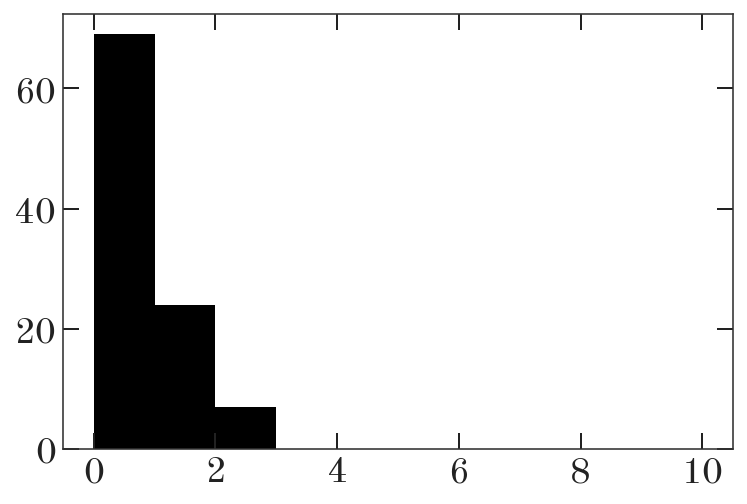

In [135]:
plt.hist(N100, bins=np.arange(0, 10+1, 1));

In [130]:
c = np.array([30., 50, 80.])
M200 = [1e6, 1e7, 1e8]*u.Msun

fac = np.log(1+c) - c/(1+c)
rho0 = 127*u.Msun/u.kpc**3 * 200/3*c**3/fac
rs = np.cbrt(M200/(2*np.pi*rho0) / fac).to(u.pc)
print(rs)

# consistency check:
# rvir = c * rs
# gp.NFWPotential(m=M200[0]/fac[0], r_s=rs[0], units=galactic).mass_enclosed([1., 0, 0]*rvir[0])[0]

[ 88.63011276 114.56867371 154.26920315] pc


In [80]:
# gd1_ann_mask = ((orbits.spherical.distance > 12*u.kpc) &
#                 (orbits.spherical.distance < 18*u.kpc))
# plt.hist(gd1_ann_mask.sum(axis=0) / gd1_ann_mask.shape[0], bins='auto');